# Underneath the Pipeline

This tutorial executes a given pipeline while also viewing the intermediate results. It can be applied to any pipeline available in the Orion repository. In this edition, we will be viewing the `tadgan` pipeline.

First let's load a demo dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from orion.data import load_signal

signal = load_signal('S-1')
signal_without_anom = load_signal('S-1-train')
signal_with_anom = load_signal('S-1-test')
signal.head()

,timestamp,value
0,1222819200,-0.366359
1,1222840800,-0.394108
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


Load the desired pipeline and setup hyperparameters as necessary

In [4]:
from mlblocks import MLPipeline

hyper = { 
    "orion.primitives.tadgan.TadGAN#1": { 
        "epochs": 5, 
        "verbose": True,
        "validation_split": 0.0
    } 
}  

pipeline = MLPipeline('tadgan')
pipeline.set_hyperparameters(hyper)

# Step by Step Executation

Now we view the intermediate results by looking at the context at each step. First we go through the training process, then we continue to the detection sequences.

## Training

### step 0: time_segments_aggregate

equally space the timeseries

In [5]:
step = 0
context = pipeline.fit(signal, output_=step)

In [6]:
context.keys()

dict_keys(['X', 'index'])

### step 1: SimpleImputer

impute missing values

In [7]:
step = 1
context = pipeline.fit(**context, output_=step, start_=step)

In [8]:
context.keys()

dict_keys(['index', 'X'])

### step 2: MinMaxScaler

scale the data between -1 and 1

In [9]:
step = 2
context = pipeline.fit(**context, output_=step, start_=step)

In [10]:
context.keys()

dict_keys(['index', 'X'])

### step 3: rolling_window_sequences

generate training examples from rolling window sequences

In [11]:
step = 3
context = pipeline.fit(**context, output_=step, start_=step)

In [12]:
context.keys()

dict_keys(['index', 'X', 'y', 'X_index', 'target_index'])

### step 4: TadGAN

train the TadGAN model using the generated window sequences

In [13]:
step = 4
context = pipeline.fit(**context, output_=step, start_=step)

Epoch 1/5
157/157 [==============================] - 38s 241ms/step - Cx_loss: -1.5144 - Cz_loss: 0.5537 - EG_loss: 0.9412
Epoch 2/5
157/157 [==============================] - 40s 257ms/step - Cx_loss: -1.2406 - Cz_loss: 0.3370 - EG_loss: -0.8431
Epoch 3/5
157/157 [==============================] - 43s 272ms/step - Cx_loss: -0.9864 - Cz_loss: 0.4400 - EG_loss: -1.5019
Epoch 4/5
157/157 [==============================] - 37s 235ms/step - Cx_loss: -0.8890 - Cz_loss: 0.2945 - EG_loss: -1.7481
Epoch 5/5
157/157 [==============================] - 36s 232ms/step - Cx_loss: -0.7270 - Cz_loss: 0.2340 - EG_loss: -2.1020


In [14]:
context.keys()

dict_keys(['index', 'X_index', 'target_index', 'X', 'y', 'y_hat', 'critic'])

## Detecting

We can either use another part of the signal or the same signal. If you are using the same signal, there is no reseaon to repeat step 0 - 3.

### step 0 - 3: similar to the previous steps
All previous time series processing applied in a single line

In [15]:
step = 3
context = pipeline.predict(signal, output_=step)

### step 4: TadGAN predictions and critic output
get the predictions and critic values for the data

In [17]:
step = 4
context = pipeline.predict(**context, output_=step, start_=step)

### step 5: calculate error
calculate the error from reconstruction error and critic score

In [18]:
step = 5
context = pipeline.predict(**context, output_=step, start_=step)

In [19]:
context.keys()

dict_keys(['index', 'y', 'X_index', 'target_index', 'y_hat', 'critic', 'X', 'errors', 'true_index', 'true', 'predictions'])

### step 6: find anomalies
use the calculated error to threshold value and locate anomalies

In [22]:
step = 6
context = pipeline.predict(**context, output_=step, start_=step)

In [24]:
context['y']

array([[1.26554400e+09, 1.26796320e+09, 1.18218331e-01],
       [1.34971920e+09, 1.35233280e+09, 1.84928257e-01],
       [1.40136480e+09, 1.40542560e+09, 1.75258103e+00]])

---

In [38]:
import pandas as pd
import numpy as np

dummy =  pd.DataFrame({"timestamp": list(range(0, 21600*1000, 21600)), 
                       "value": np.random.randint(-15, 15, 1000)})

In [13]:
step = 3
context = pipeline.predict(signal, output_=step)

In [45]:
context.keys()

dict_keys(['X', 'index', 'y', 'X_index', 'target_index'])

In [14]:
import numpy as np

def unroll_ts(y_hat):
    predictions = list()
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + (y_hat.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])

            if intermediate:
                predictions.append(np.median(np.asarray(intermediate)))

    return np.asarray(predictions[pred_length-1:])

In [15]:
step = 4
context = pipeline.predict(**context, output_=step, start_=step)

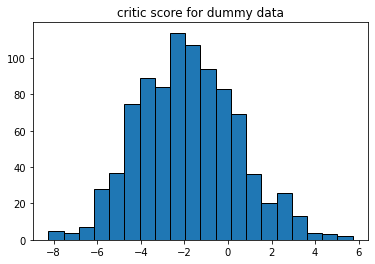

In [43]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(context['critic'].flatten(), bins=20, edgecolor='black')
plt.title("critic score for dummy data");

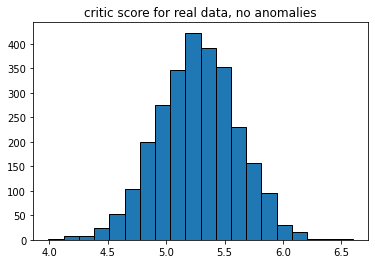

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(context['critic'].flatten(), bins=20, edgecolor='black')
plt.title("critic score for real data, no anomalies");

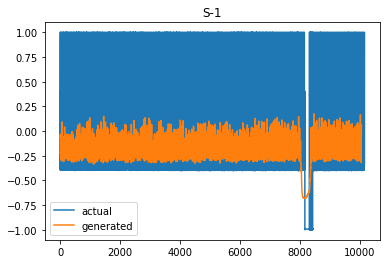

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(signal['value'], label='actual')
plt.plot(unroll_ts(context['y_hat']), label='generated')
plt.legend()
plt.title('S-1')
plt.savefig("tf2_s1.png", dpi=300);

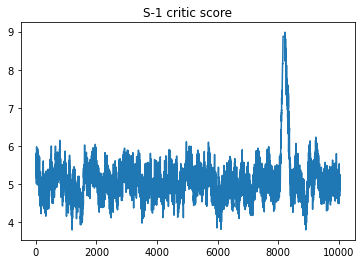

In [21]:
plt.title('S-1 critic score')
plt.plot(context['critic'])
plt.savefig("tf2_s1_critic.png", dpi=300);

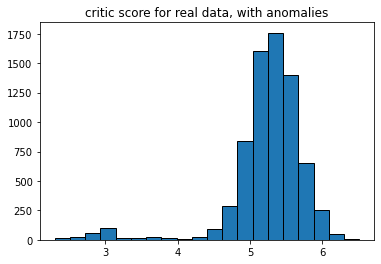

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.hist(context['critic'].flatten(), bins=20, edgecolor='black')
plt.title("critic score for real data, with anomalies");